## Preprocessing of data
The objective is to identify forcing and location regions for the extreme wave event. 

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import my_functions as my

In [2]:
ds_atm = xr.open_dataset('ERA5_atm_122025.nc')
ds_ocean = xr.open_dataset('ERA5_ocean_122025.nc')

#ds_atm has higher resolution than ds_ocean, interpolatig ds_atm to ds_ocean grid
ds_atm_interp = ds_atm.interp(latitude=ds_ocean.latitude, longitude=ds_ocean.longitude)

ds = xr.merge([ds_atm_interp, ds_ocean], join='exact', compat='override')
ds = ds.sel(latitude=slice(60,20), longitude=slice(-40,10))
ds_canary = ds.sel(latitude=slice(30,26), longitude=slice(-19,-12))
ds

<xarray.Dataset> Size: 243MB
Dimensions:     (valid_time: 744, latitude: 81, longitude: 101)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 6kB 2025-12-01 ... 2025-12-31T23:...
  * latitude    (latitude) float64 648B 60.0 59.5 59.0 58.5 ... 21.0 20.5 20.0
  * longitude   (longitude) float64 808B -40.0 -39.5 -39.0 ... 9.0 9.5 10.0
    number      int64 8B ...
    expver      (valid_time) <U4 12kB ...
Data variables:
    u10         (valid_time, latitude, longitude) float64 49MB 6.793 ... 1.212
    v10         (valid_time, latitude, longitude) float64 49MB -17.14 ... 0.4037
    sp          (valid_time, latitude, longitude) float64 49MB 9.912e+04 ... ...
    swh         (valid_time, latitude, longitude) float32 24MB ...
    pp1d        (valid_time, latitude, longitude) float32 24MB ...
    shts        (valid_time, latitude, longitude) float32 24MB ...
    shww        (valid_time, latitude, longitude) float32 24MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-02-09T11:30 GRIB to CDM+CF via cfgrib-0.9.1...

### Computing anomalies

In [ ]:
# Computing anomalies by rolling mean to isolate storms, forcing and remove background.
# Using rolling mean instead of climatology is questionable but seem to work for identification. 
# Also, less data is needed.

# Computing min surface pressure anomaly per day, gives storm location. 3 days window.
ds = my.compute_anomaly(ds, variable='sp', window_hours=24*3, method='min')

# For detecting anomalies in wind, total speed is more interesting than component velocities
ds['wind_speed'] = np.sqrt(ds['u10']**2 + ds['v10']**2)
ds['wind_speed'].attrs.update({
    'units': 'm s**-1',
    'long_name': 'Wind Speed',
    'standard_name': 'wind_speed'
})

# Computing mean wind anomaly per day, as sustained wind is what generates swell. 3 days window.
ds = my.compute_anomaly(ds, variable='wind_speed', window_hours=24*3, method='mean')

# Computing max significant height of wind waves anomaly, 3 day swindow to capture local wind-sea growth.
ds = my.compute_anomaly(ds, variable='shww', window_hours=24*3, method='max')

# Computing max significant height of swell anomaly, 5 days window to capture propagation.
ds = my.compute_anomaly(ds, variable='shts', window_hours=24*5, method='max')

# Computing max significant height of combined waves anomaly, 4 days window to capture extreme wave event at Canary Islands.
ds_canary = my.compute_anomaly(ds_canary, variable='swh', window_hours=24*4, method='max')


### Identification of extreme forcing and event dates
The expectation is for surface pressure to drop first, then strong winds which generate wind waves, later swell from suistained wind.

Dates of impact are expected to be 12-15 dec.

(Note: the method of plotting selected extreme dates was not that effective)

In [ ]:
# Before impact:

# Days with lowest surface pressure anomaly
dates_sp = my.get_extreme_dates(ds, 'sp_anomaly_min', '2025-12-06', '2025-12-12', method='min', n=4)

# Days with highest mean wind anomaly
dates_wind = my.get_extreme_dates(ds, 'wind_speed_anomaly_mean', '2025-12-06', '2025-12-12', method='max', n=4)

# Days with highest wind waves anomalies
dates_shww = my.get_extreme_dates(ds, 'shww_anomaly_max', '2025-12-06', '2025-12-12', method='max', n=4)

# Days with highest swell waves anomalies
dates_shts = my.get_extreme_dates(ds, 'shts_anomaly_max', '2025-12-06', '2025-12-12', method='max', n=4)

# During impact:
# Day with highest combined waves anomalies
dates_swh = my.get_extreme_dates(ds_canary, 'swh_anomaly_max', '2025-12-10', '2025-12-17', method='max', n=1)


Days with lowest values of sp_anomaly_min: ['2025-12-08T00:00:00' '2025-12-09T00:00:00' '2025-12-10T00:00:00'
 '2025-12-11T00:00:00'] 
Values: [-1517.77256944 -1948.3203125  -2268.42447917 -2444.734375  ] 

Days with highest values of wind_speed_anomaly_mean: ['2025-12-08T00:00:00' '2025-12-10T00:00:00' '2025-12-11T00:00:00'
 '2025-12-12T00:00:00'] 
Values: [5.29222454 5.22097727 5.12415573 4.98667285] 

Days with highest values of shww_anomaly_max: ['2025-12-06T00:00:00' '2025-12-07T00:00:00' '2025-12-10T00:00:00'
 '2025-12-11T00:00:00'] 
Values: [7.252409  7.076938  6.9836154 6.78353  ] 

Days with highest values of shts_anomaly_max: ['2025-12-06T00:00:00' '2025-12-07T00:00:00' '2025-12-11T00:00:00'
 '2025-12-12T00:00:00'] 
Values: [5.9142265 5.042508  5.0245113 4.6303244] 

Days with highest values of swh_anomaly_max: ['2025-12-13T00:00:00'] 
Values: [2.9262805] 



### Visualization of extreme dates and selecting of regions

#### Potential forcing region A

Low surface pressure matches strong consistent winds, wind waves and formation of swell that propagates towards the event region.

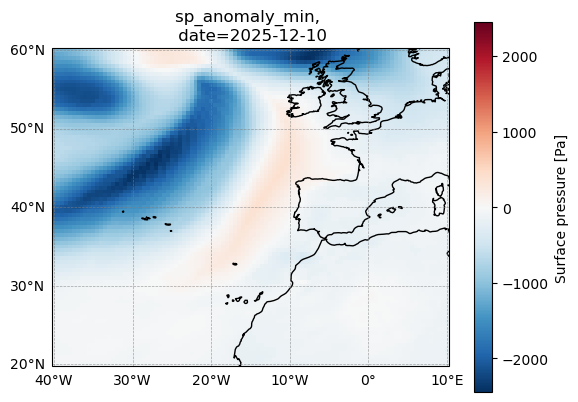

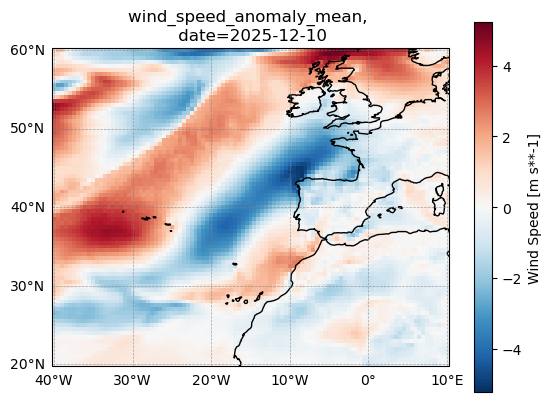

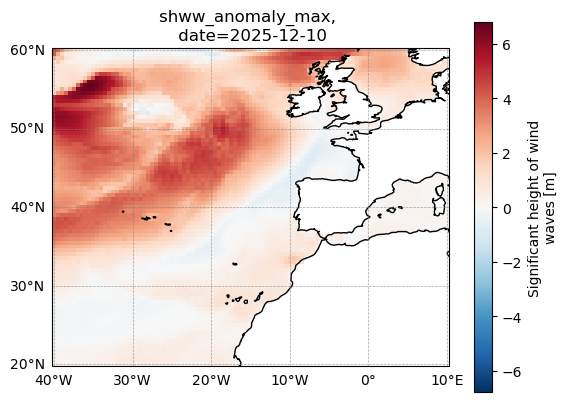

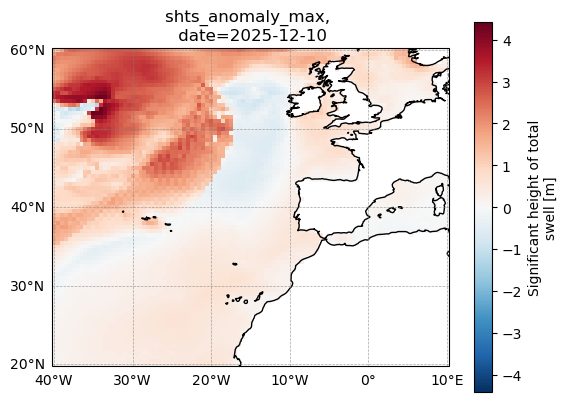

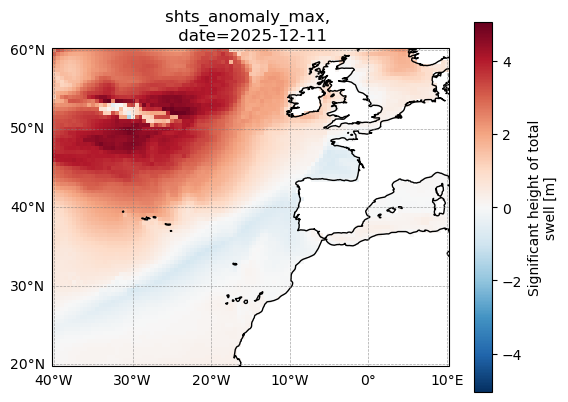

In [ ]:
my.plotting_func(ds=ds, variable='sp_anomaly_min', date='2025-12-10')
my.plotting_func(ds=ds, variable='wind_speed_anomaly_mean', date='2025-12-10')
my.plotting_func(ds=ds, variable='shww_anomaly_max', date='2025-12-10')
my.plotting_func(ds=ds, variable='shts_anomaly_max', date='2025-12-10')
my.plotting_func(ds=ds, variable='shts_anomaly_max', date='2025-12-11')

Chosen coordinates for potential forcing region A is:

Latitude: (50°, 40°) N

Longitude: (30°, 20°) W

In [17]:
forcing_A = ds.sel(latitude=slice(50,40), longitude=slice(-30,-20))

#### Potential forcing region B

This region is closer to the event region, but was more difficult to detect.
Low surface pressure (though not a strong anomaly) matches wind, wind waves and formation of swell. 
Difficult to see if swell from forcing region B is propagating towards event location.

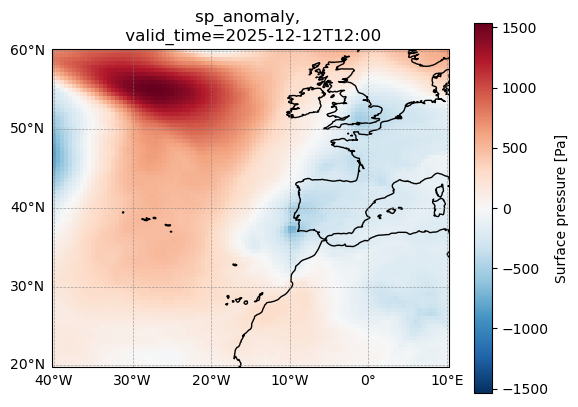

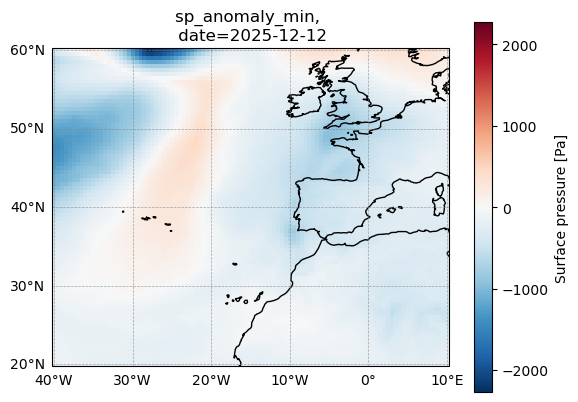

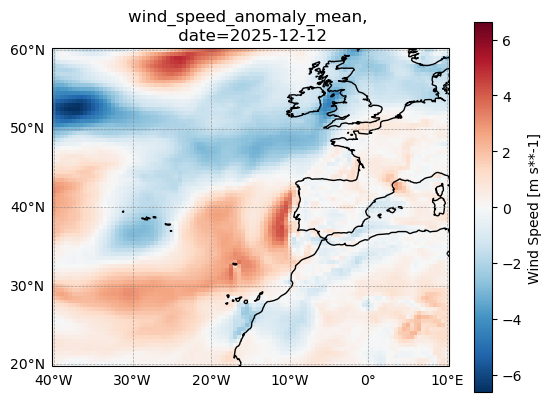

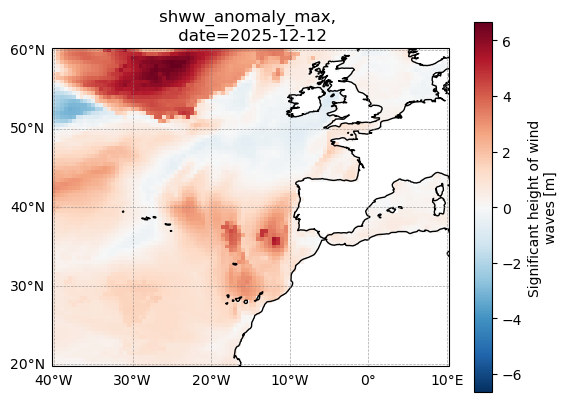

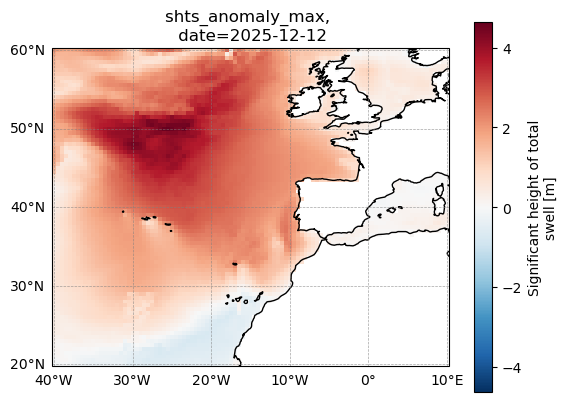

In [ ]:
my.plotting_func(ds=ds, variable='sp_anomaly', valid_time='2025-12-12T12:00')
my.plotting_func(ds=ds, variable='sp_anomaly_min', date='2025-12-12')
my.plotting_func(ds=ds, variable='wind_speed_anomaly_mean', date='2025-12-12')
my.plotting_func(ds=ds, variable='shww_anomaly_max', date='2025-12-12')
my.plotting_func(ds=ds, variable='shts_anomaly_max', date='2025-12-12')

Chosen coordinates for potential forcing region B is:

Latitude: (40°, 30°) N

Longitude: (20°, 10°) W

In [18]:
forcing_B = ds.sel(latitude=slice(40,30), longitude=slice(-20,-10))

#### Checking event region

Selecting North of the Canary Islands as that is the area of most impact.

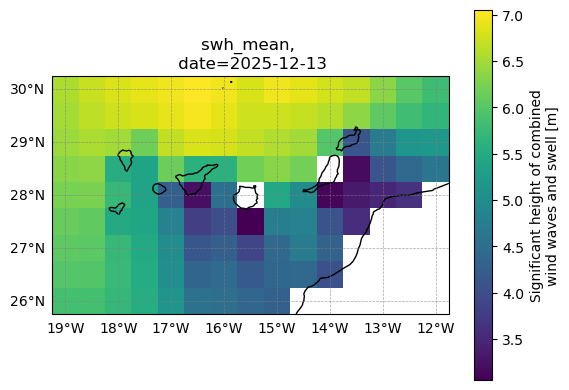

In [19]:
swh_mean = ds_canary['swh'].groupby('valid_time.date').max('valid_time')
swh_mean['date']= pd.to_datetime(swh_mean['date'])
ds_canary['swh_mean'] = swh_mean

my.plotting_func(ds=ds_canary, variable='swh_mean', date='2025-12-13')

event = ds_canary.sel(latitude=slice(30,28), longitude=slice(-19,-13))

### Converting to data frame

In [ ]:
# Resampling to reduce noise
forcing_A = forcing_A.resample(valid_time='6h').mean()
forcing_B = forcing_B.resample(valid_time='6h').mean()
event = event.resample(valid_time='6h').mean()

# Taking mean over regions 
forcing_A = forcing_A.mean(dim=['latitude', 'longitude'])
forcing_B = forcing_B.mean(dim=['latitude', 'longitude'])
event = event.mean(dim=['latitude', 'longitude'])

variables_wanted = [
    "u10", "v10", "sp", 
    "swh", "pp1d", "shts", "shww",
    "location"
]
forcing_A = my.select_variables(forcing_A, 'forcing_A', variables_wanted)
forcing_B = my.select_variables(forcing_B, 'forcing_B', variables_wanted)
event = my.select_variables(event, 'event', variables_wanted)


In [21]:
df_A = forcing_A.to_dataframe()
df_B = forcing_B.to_dataframe()
df_event = event.to_dataframe()

df = pd.concat([df_A, df_B, df_event])

In [23]:
df

,u10,v10,sp,swh,pp1d,shts,shww,location
valid_time,,,,,,,,
2025-12-01 00:00:00,13.635009,-2.569664,101173.330711,4.430183,10.823172,2.148580,3.757942,forcing_A
2025-12-01 06:00:00,13.021421,-6.996197,101508.244166,5.323988,11.158627,2.576043,4.563890,forcing_A
2025-12-01 12:00:00,12.583745,-6.514074,101805.234883,5.703995,12.156568,3.245259,4.406491,forcing_A
2025-12-01 18:00:00,12.157771,-6.771453,101964.931571,5.933010,12.854448,3.643926,4.293433,forcing_A
2025-12-02 00:00:00,11.821255,-7.508423,102062.226261,6.044052,13.271851,4.032465,4.158156,forcing_A
...,...,...,...,...,...,...,...,...
2025-12-30 18:00:00,2.741900,1.413604,101890.998077,1.688904,14.060192,1.679525,0.134348,event
2025-12-31 00:00:00,2.063137,2.138546,101780.944391,1.562467,13.486410,1.553016,0.127348,event
2025-12-31 06:00:00,1.394902,3.694098,101745.453526,1.424851,12.913450,1.401580,0.205230,event


In [24]:
df.to_csv('df.csv')
df.to_excel("df.xlsx", index=True)
